In [68]:
import nltk, re, math
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import sys, os
sys.path.append(os.path.abspath(os.path.join('../../functions/')))

import prep_functions
fetcher = prep_functions.ExchangeRateFetcher('KRW')

In [6]:
origin_india_df = pd.read_csv('../../data/amazon.csv')
india_df = pd.read_csv('../../data/amazon_india.csv')
canada_df = pd.read_csv('../../data/amazon_canada.csv')
uk_df = pd.read_csv('../../data/amazon_uk.csv')
usa_df = pd.read_csv('../../data/amazon_usa.csv')

In [7]:
# price 관련 컬럼 수정
price_cols = ['discounted_price', 'actual_price']
origin_india_df[price_cols] = origin_india_df[price_cols].replace({'₹': '', ',': ''}, regex=True).astype(float)
origin_india_df['discount_percentage'] = origin_india_df['discount_percentage'].replace('%', '', regex=True).astype(float)

In [8]:
# rating 관련 컬럼 수정
origin_india_df = origin_india_df[origin_india_df['rating_count'].notnull()]
origin_india_df = origin_india_df.reset_index().drop(columns=('index'))
origin_india_df.loc[origin_india_df['rating'].str.contains('|', regex=False), 'rating'] = 3.8

In [9]:
def drop_price(df):
    df.drop(columns=['discounted_price','actual_price'], inplace=True)
    
drop_price(india_df)
drop_price(canada_df)
drop_price(usa_df)
uk_df.drop(columns=['discounted_price'], inplace=True)

In [10]:
# price 통화 변경
def convert_currency(row, col):
    if row[col] == 0:
        return 0
    return fetcher.convert(row[col], 'INR', 'KRW')

origin_india_df['discounted_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'discounted_price'), axis=1).astype(int)
origin_india_df['actual_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'actual_price'), axis=1).astype(int)

In [11]:
origin_india_df['rating'] = origin_india_df['rating'].astype(float)
origin_india_df['rating_count'] = origin_india_df['rating_count'].str.replace(',','').astype(int)
origin_india_df = origin_india_df.drop_duplicates(subset=['product_id', 'product_name', 'discounted_price_KRW', 'actual_price_KRW'], keep='last')

In [12]:
# 카테고리 추가
origin_india_df.loc[:, 'big_category'] = origin_india_df['category'].apply(lambda x: x.split('|')[0])
origin_india_df.loc[:, 'small_category'] = origin_india_df['category'].apply(lambda x: x.split('|')[-2])

---

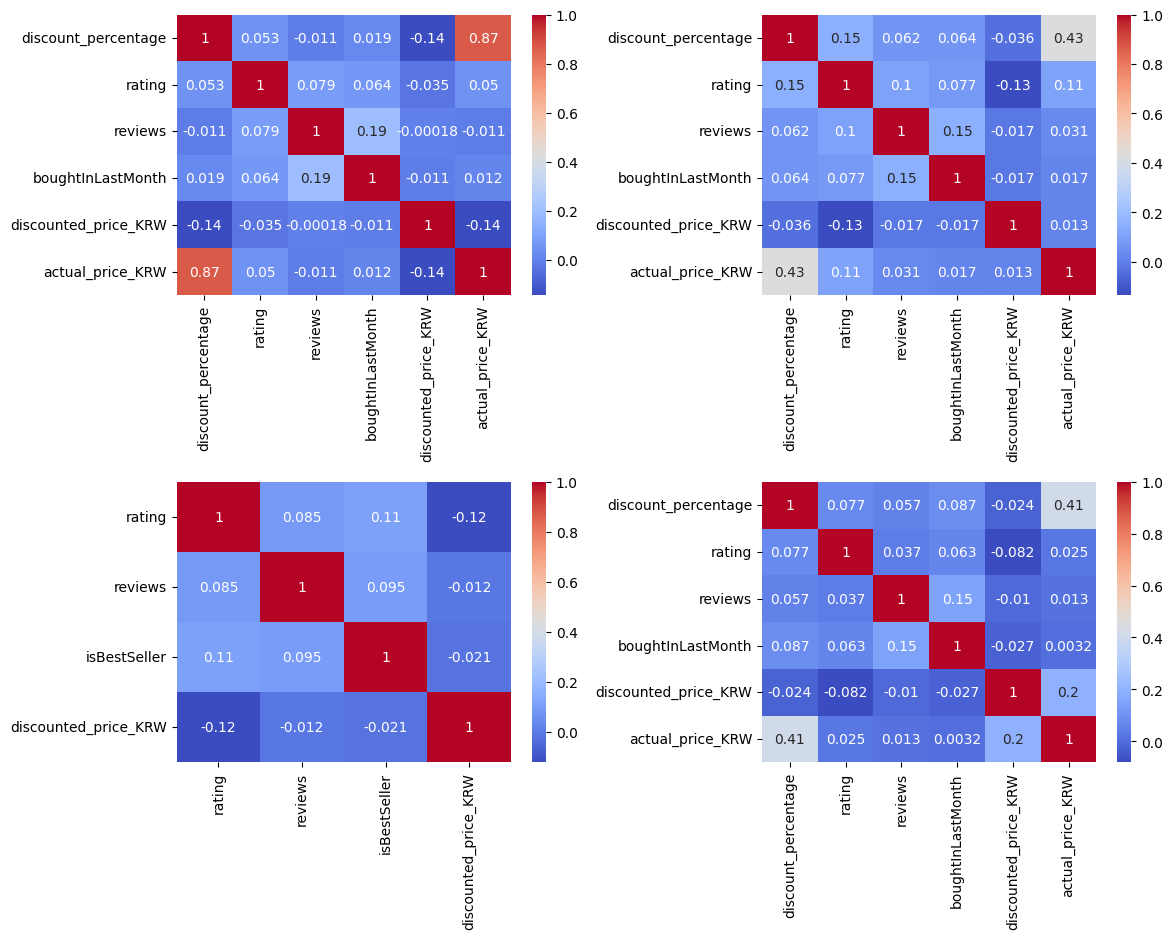

In [26]:
# 상관계수
def numeric(dfs):
    num_dfs = [df.select_dtypes(include=['number']) for df in dfs]
    return check_corr(num_dfs)

def check_corr(dfs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for ax, df in zip(axes.flat, dfs):
        corr = df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

numeric([india_df, canada_df, uk_df, usa_df])

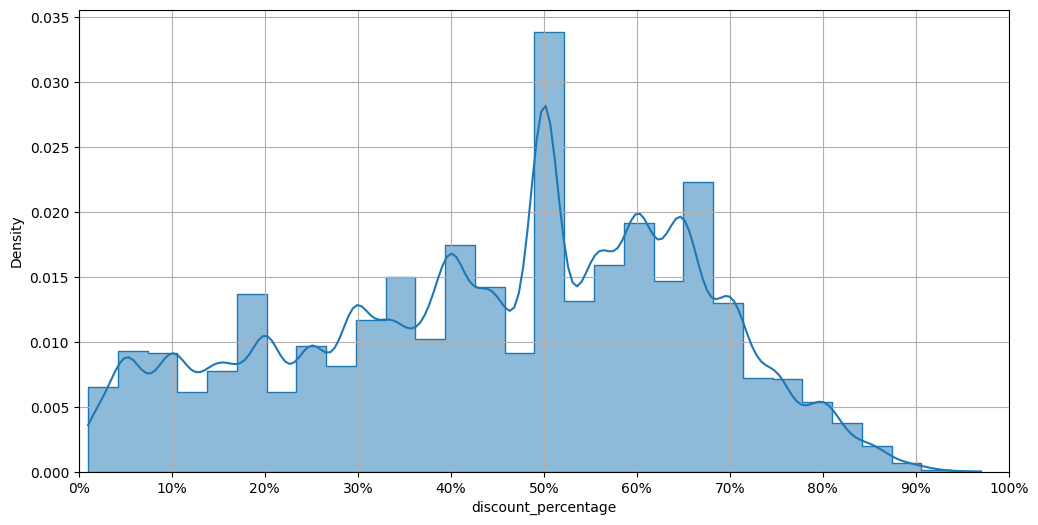

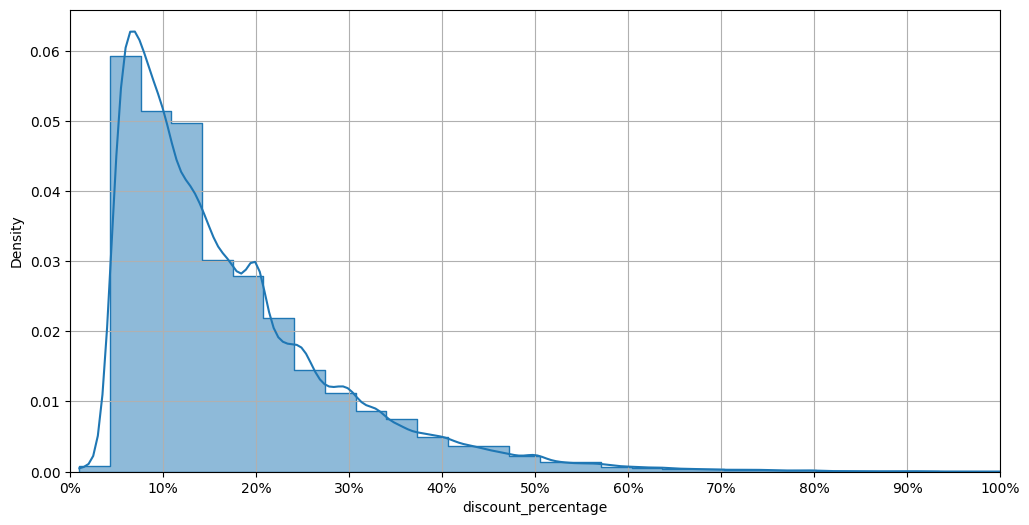

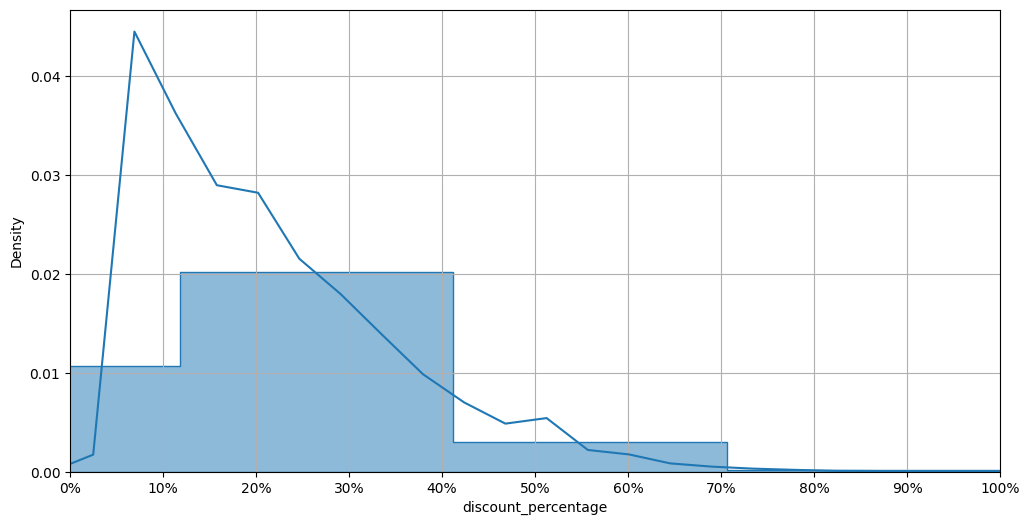

In [27]:
# 할인율 0인 데이터 제외, 할인율 빈도
def filter_zero_pc(dfs):
    filtered = [df.query('discount_percentage != 0') for df in dfs]
    discounted_pc_histogram(filtered)
    
def discounted_pc_histogram(dfs):
    for df in dfs:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='discount_percentage', bins=30, kde=True, stat='density', element='step')
        
        plt.xlim(0, 100)
        ticks = range(0, 101, 10)
        plt.xticks(ticks, [f'{tick}%' for tick in ticks])
        plt.grid()
        plt.show()
        
filter_zero_pc([india_df, canada_df, usa_df])

----

In [97]:
countries = ['India', 'Canada', 'UK', 'USA']

def elbow_graph(dfs):
    numeric_columns = ['discounted_price_KRW', 'rating', 'reviews']
    # dfs = [df[numeric_columns].query('discounted_price_KRW != 0') for df in dfs]
    dfs = [df[numeric_columns] for df in dfs]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for i, df in enumerate(dfs):
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)

        inertia = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
            kmeans.fit(df_scaled)
            inertia.append(kmeans.inertia_)
        axes[i].plot(K, inertia, 'bx-')
        axes[i].set_title(f'{countries[i]}')
        
    plt.tight_layout()
    plt.show()

def price_rating_reviews_kmeans_clustering(dfs, n_clusters=4):
    result = []
    numeric_columns = ['discounted_price_KRW', 'rating', 'reviews']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, df in enumerate(dfs):
        # df = df.query('discounted_price_KRW != 0')
        
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df[numeric_columns])

        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'])
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        pca_df['cluster'] = kmeans.fit_predict(df_scaled)
        df['cluster'] = kmeans.fit_predict(df_scaled)

        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', 
                        palette='viridis', alpha=0.7, ax=axes[i])

        axes[i].set_title(f'PCA K-means Clustering for {countries[i]}')
        axes[i].set_xlabel('PCA Component 1')
        axes[i].set_ylabel('PCA Component 2')
        axes[i].set_xlim(-5, 10)
        axes[i].set_ylim(-5, 10)
        
        result.append(df)
        
    plt.tight_layout()
    plt.show()
    
    return result

In [98]:
india_df = india_df[(india_df['discounted_price_KRW'] != 0) & (india_df['actual_price_KRW'] != 0)]
canada_df = canada_df[(canada_df['discounted_price_KRW'] != 0) & (canada_df['actual_price_KRW'] != 0)]
usa_df = usa_df[(india_df['discounted_price_KRW'] != 0) & (usa_df['actual_price_KRW'] != 0)]
uk_df = uk_df[uk_df['discounted_price_KRW'] != 0]

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_3409/174877343.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  usa_df = usa_df[(india_df['discounted_price_KRW'] != 0) & (usa_df['actual_price_KRW'] != 0)]


In [99]:
country = [india_df, canada_df, uk_df, usa_df]

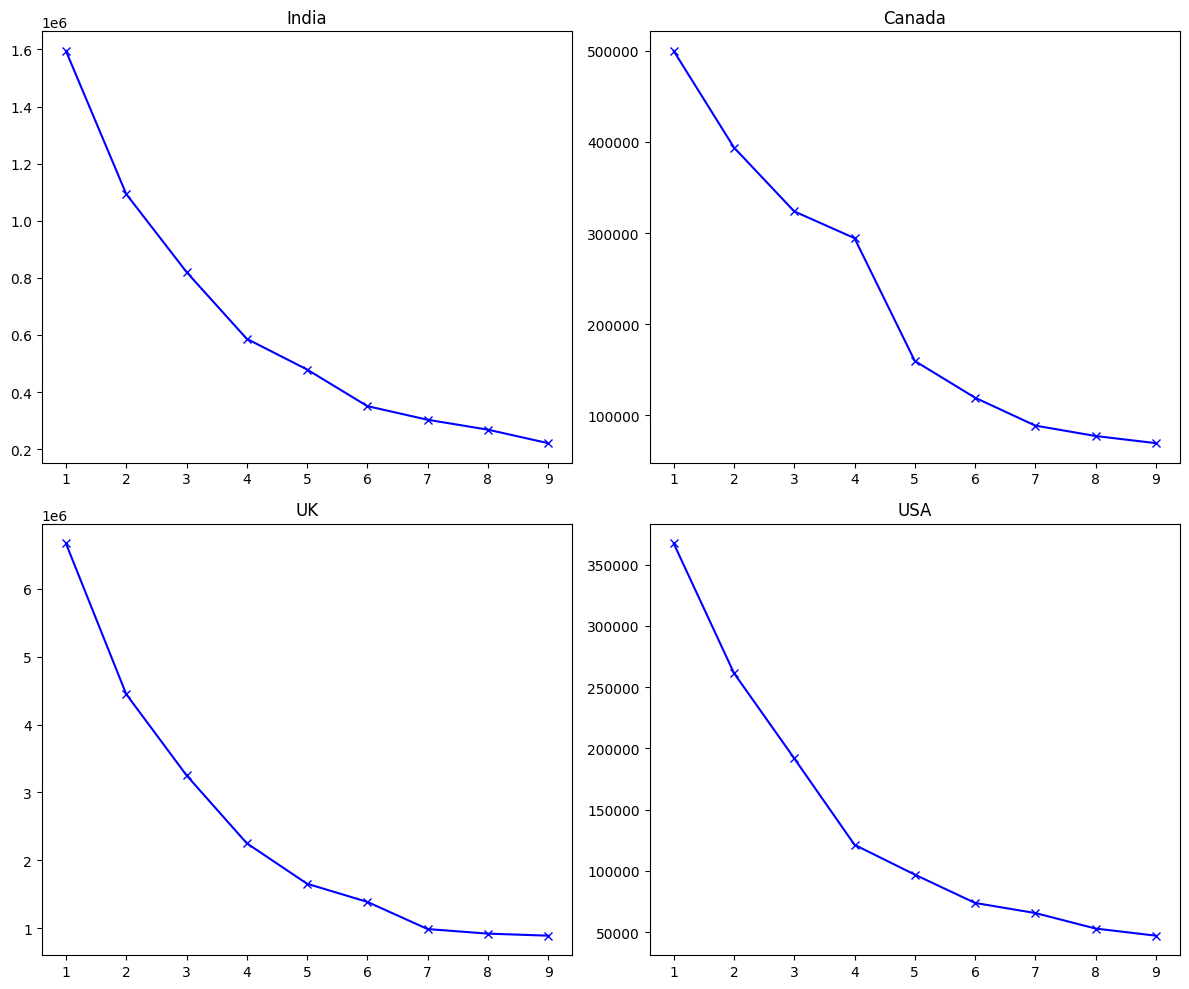

In [95]:
elbow_graph(country)

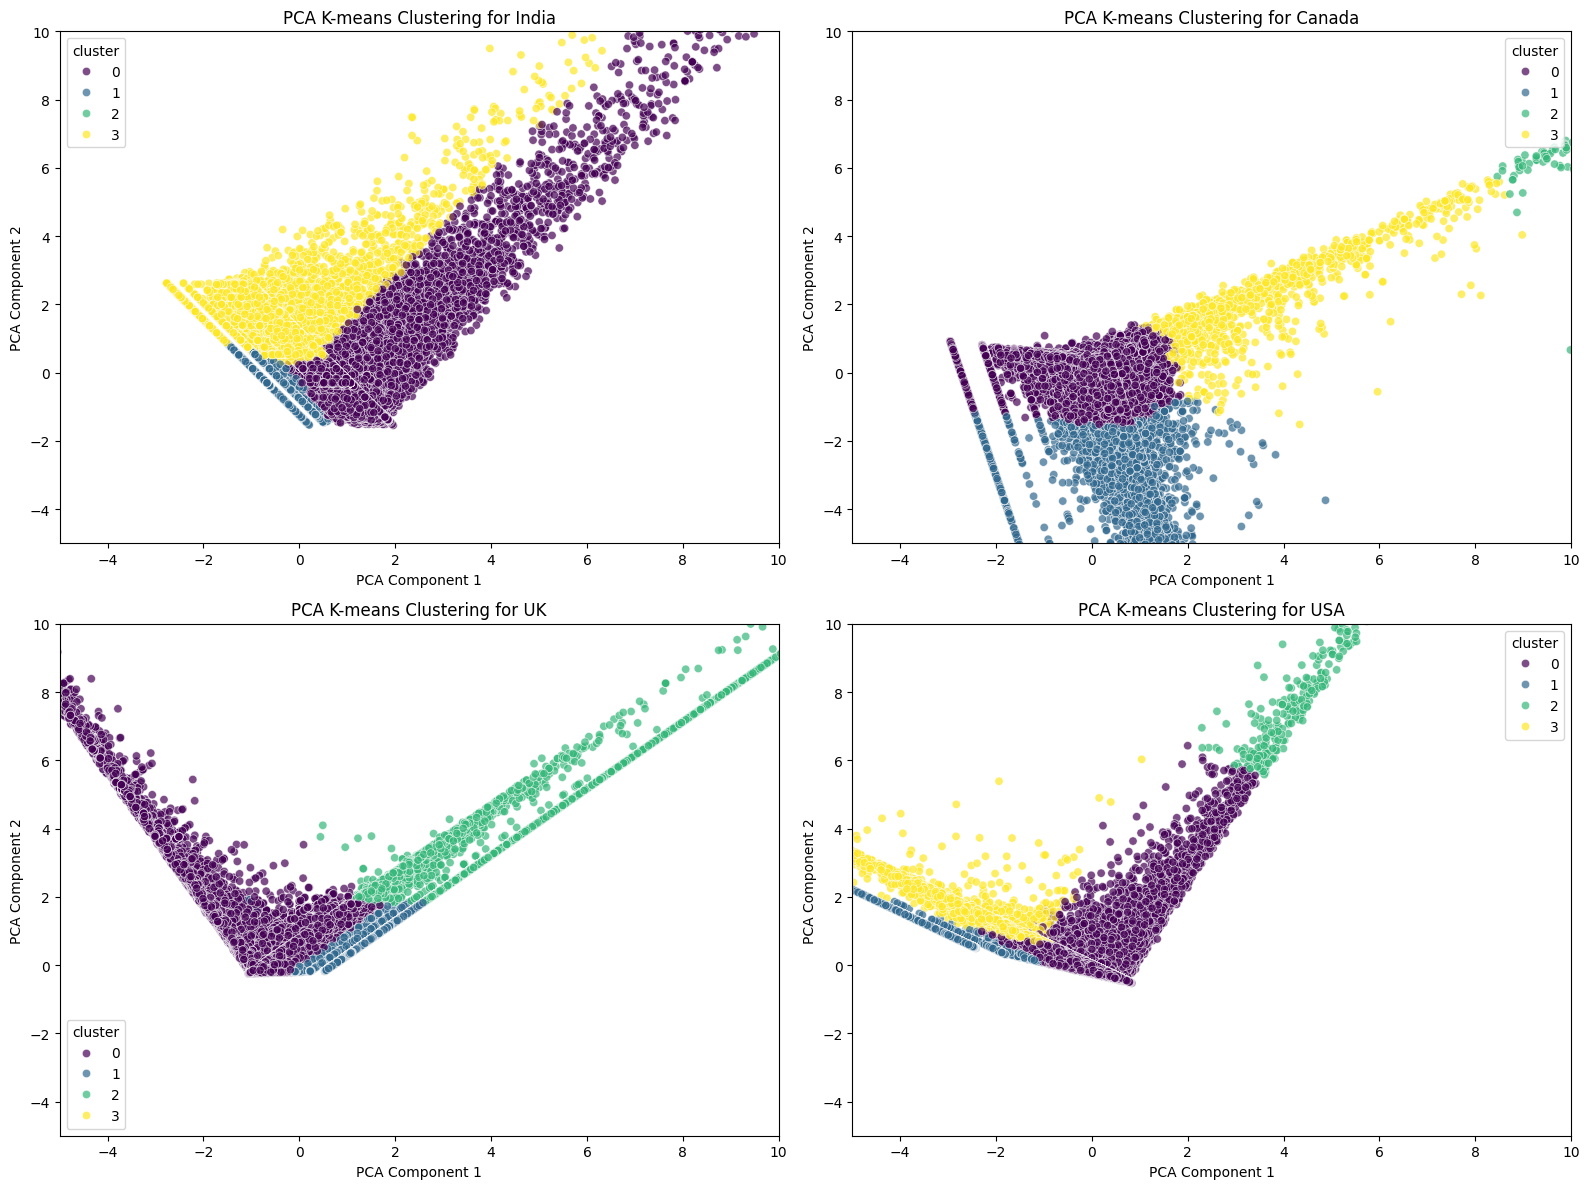

In [100]:
cluster_dfs = price_rating_reviews_kmeans_clustering(country)

In [58]:
def analyze_clusters(dfs, column_name):
    for i, df in enumerate(dfs):
        # 클러스터 분석
        cluster_analysis = df.groupby('cluster')[column_name].value_counts(normalize=True).unstack()
        
        # 히트맵 그리기
        plt.figure(figsize=(10, 7))
        sns.heatmap(cluster_analysis, cmap='YlGnBu')  # 히트맵 내부 글자 끔
        plt.title(f'Distribution of {column_name} across clusters for {countries[i]}')
        plt.show()
        
        # 클러스터별 상위 5개 카테고리 출력
        for cluster in cluster_analysis.index:
            top_5_categories = cluster_analysis.loc[cluster].nlargest(5)
            print(f"Cluster {cluster} - Top 5 {column_name} for {countries[i]}:\n", top_5_categories)
            print("-" * 50)

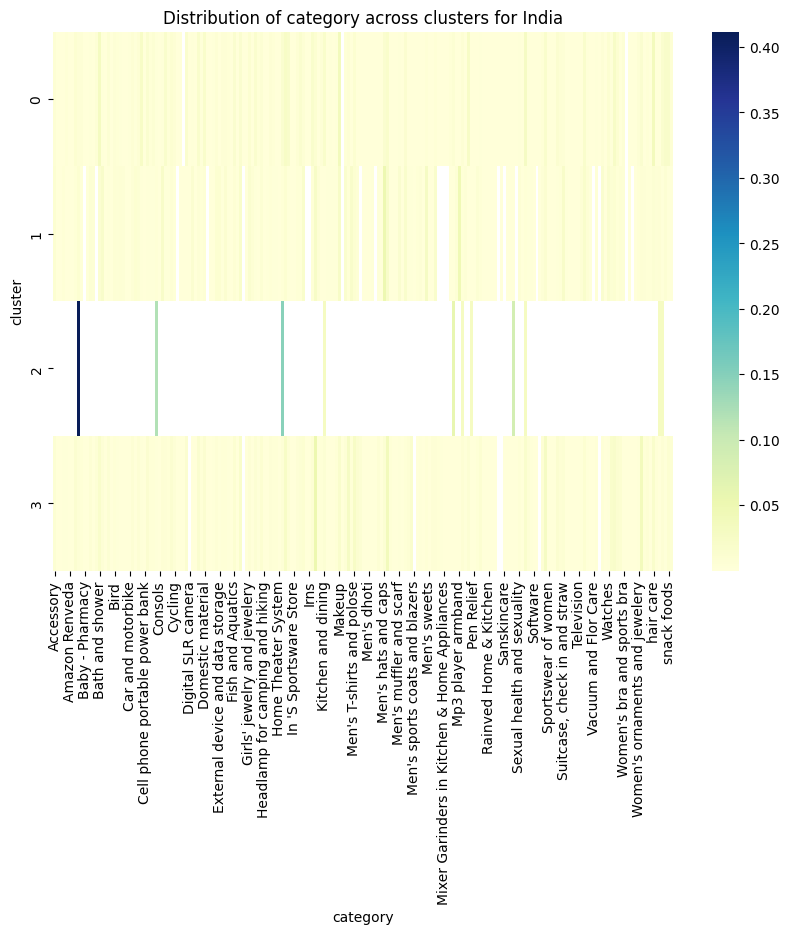

Cluster 0 - Top 5 category for India:
 category
Makeup              0.037346
hair care           0.035401
Bath and shower     0.031332
Skin care           0.027628
Home and kitchen    0.024882
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for India:
 category
Men's hats and caps    0.050391
Mp3 player armband     0.047076
Men's sunglasses       0.027683
Makeup                 0.023715
Kids shoes             0.022944
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for India:
 category
Audio headphone               0.411765
Home Theater, TV and Video    0.147059
Computer and accessories      0.117647
Sanskriti_Diares & Wipes      0.088235
Mobile and accessory          0.058824
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for India:
 category
Kids shoes                     0.053076
Women's shoes                  0.038413
Men

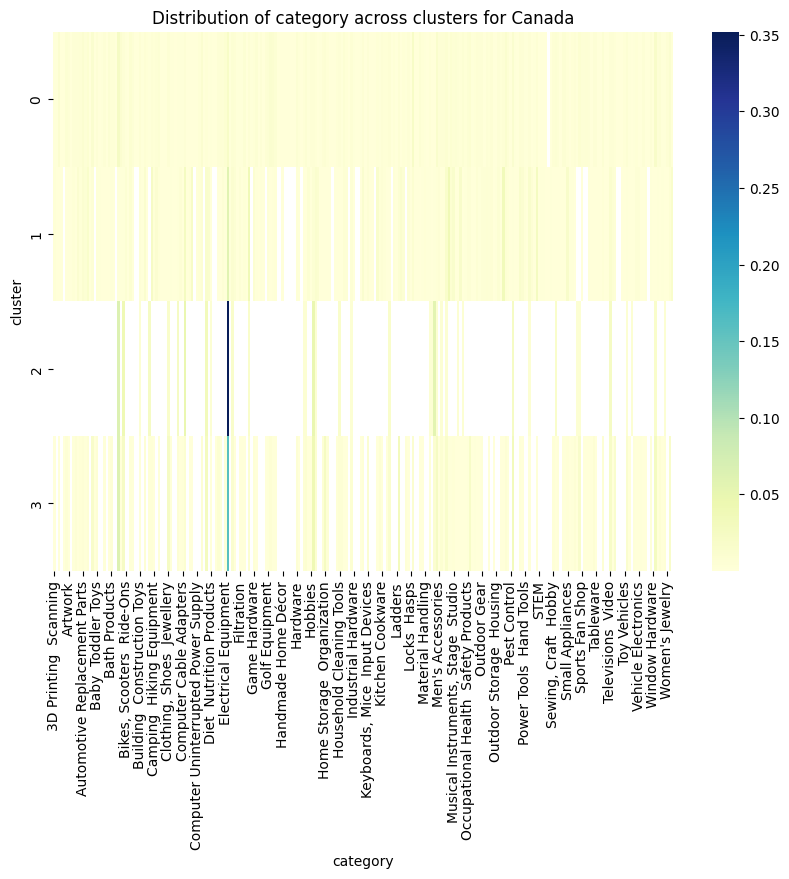

Cluster 0 - Top 5 category for Canada:
 category
Beauty                  0.023393
Electronics             0.019587
Luggage  Travel Gear    0.019343
Women                   0.018142
Men                     0.014566
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for Canada:
 category
Electronics                     0.059412
Furniture                       0.038338
Men's Watches                   0.038338
Patio Furniture  Accessories    0.033456
Computer Components             0.027265
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for Canada:
 category
Electronics            0.352
Beauty                 0.064
Memory Cards           0.056
Computer Components    0.048
Home  Kitchen          0.048
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for Canada:
 category
Electronics                             0.159236
Beauty         

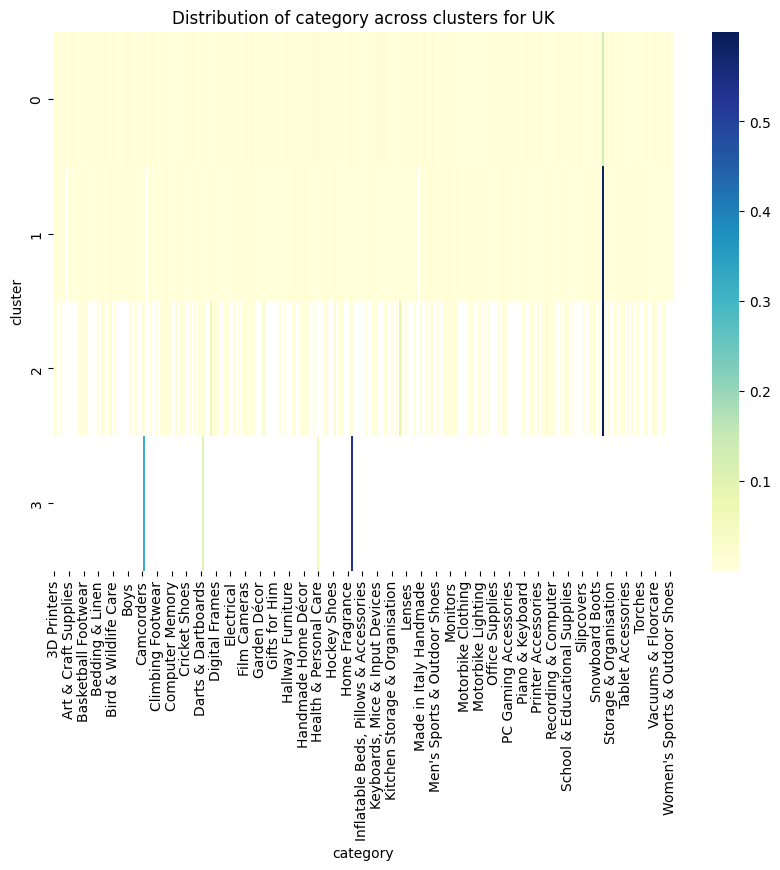

Cluster 0 - Top 5 category for UK:
 category
Sports & Outdoors    0.133448
Skin Care            0.017289
Make-up              0.016150
Men                  0.015533
Women                0.015463
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for UK:
 category
Sports & Outdoors                         0.578011
Handmade Clothing, Shoes & Accessories    0.011594
Handmade Kitchen & Dining                 0.011104
Handmade Artwork                          0.010863
Handmade Jewellery                        0.007637
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for UK:
 category
Sports & Outdoors            0.599805
Laptops                      0.092525
Desktop PCs                  0.069384
Garden Storage & Housing     0.025483
Home Audio Record Players    0.020076
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for UK:
 category


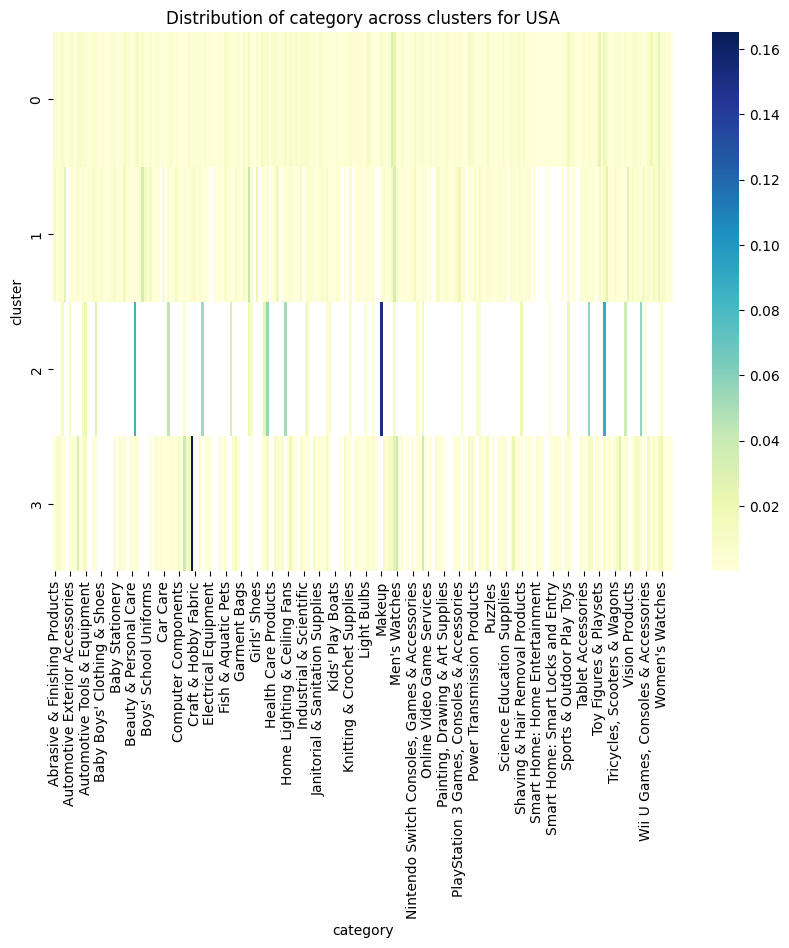

Cluster 0 - Top 5 category for USA:
 category
Men's Clothing            0.031975
Toy Figures & Playsets    0.024777
Women's Shoes             0.024688
Men's Shoes               0.024402
Toys & Games              0.020865
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for USA:
 category
Girls' Clothing                  0.042363
Boys' Clothing                   0.035443
Men's Shoes                      0.034768
Arts, Crafts & Sewing Storage    0.026667
Travel Accessories               0.026667
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for USA:
 category
Makeup                          0.150127
Toys & Games                    0.089059
Beauty Tools & Accessories      0.083969
Headphones & Earbuds            0.055980
Televisions & Video Products    0.055980
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for USA:
 category
C

In [101]:
analyze_clusters(cluster_dfs, 'category')

In [63]:
def cluster_profiles_integration(dfs, column_name):
    data = []
    
    for i, df in enumerate(dfs):
        # Iterate over each cluster
        for cluster in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster]
            
            # Top categories (빈도 상위 5개 카테고리)
            top_cats = cluster_data[column_name].value_counts(normalize=True).head(5)
            top_cats_dict = {f"top_category_{i+1}": f"{cat} ({pct:.2%})" 
                             for i, (cat, pct) in enumerate(top_cats.items())}
            
            # Combine all information
            cluster_profile = {'country': countries[i], 'cluster': cluster, **top_cats_dict}
            data.append(cluster_profile)
    
    # Create DataFrame
    profiles_df = pd.DataFrame(data)
    profiles_df.set_index(['country', 'cluster'], inplace=True)
    profiles_df = profiles_df.sort_index(level=['country', 'cluster'])
    
    return profiles_df


def cluster_profiles_division(dfs, column_name):
    country_dfs = {}
    
    for i, df in enumerate(dfs):
        data = []
        
        # Iterate over each cluster
        for cluster in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster]
            
            # Top categories (빈도 상위 5개 카테고리)
            top_cats = cluster_data[column_name].value_counts(normalize=True).head(5)
            top_cats_dict = {f"top_category_{i+1}": f"{cat} ({pct:.2%})" 
                             for i, (cat, pct) in enumerate(top_cats.items())}
            
            # Combine all information
            cluster_profile = {'country': countries[i], 'cluster': cluster, **top_cats_dict}
            data.append(cluster_profile)
        
        # Create DataFrame for the current country
        profiles_df = pd.DataFrame(data)
        profiles_df.set_index(['country', 'cluster'], inplace=True)
        profiles_df = profiles_df.sort_index(level=['country', 'cluster'])
        
        # Store the DataFrame for each country
        country_dfs[countries[i]] = profiles_df
    
    return country_dfs

In [102]:
# 통합 df
profiles_df = cluster_profiles_integration(cluster_dfs, 'category')
display(profiles_df)

top_category_1  \
country cluster                                                      
Canada  0                                           Beauty (2.34%)   
        1                                      Electronics (5.94%)   
        2                                     Electronics (35.20%)   
        3                                     Electronics (15.92%)   
India   0                                           Makeup (3.73%)   
        1                              Men's hats and caps (5.04%)   
        2                                 Audio headphone (41.18%)   
        3                                       Kids shoes (5.31%)   
UK      0                               Sports & Outdoors (13.34%)   
        1                               Sports & Outdoors (57.80%)   
        2                               Sports & Outdoors (59.98%)   
        3        Household Batteries, Chargers & Accessories (5...   
USA     0                                   Men's Clothing (3.20%)   
        1                                  Girls' Clothing (4.24%)   
        2                                          Makeup (15.01%)   
        3                             Computers & Tablets (16.52%)   

                                                 top_category_2  \
country cluster                                                   
Canada  0                                   Electronics (1.96%)   
        1                                     Furniture (3.83%)   
        2                                        Beauty (6.40%)   
        3                                        Beauty (6.41%)   
India   0                                     hair care (3.54%)   
        1                            Mp3 player armband (4.71%)   
        2                   Home Theater, TV and Video (14.71%)   
        3                                 Women's shoes (3.84%)   
UK      0                                     Skin Care (1.73%)   
        1        Handmade Clothing, Shoes & Accessories (1.16%)   
        2                                       Laptops (9.25%)   
        3                   Camera & Photo Accessories (31.58%)   
USA     0                        Toy Figures & Playsets (2.48%)   
        1                                Boys' Clothing (3.54%)   
        2                                  Toys & Games (8.91%)   
        3                                 Men's Watches (4.01%)   

                                     top_category_3  \
country cluster                                       
Canada  0              Luggage  Travel Gear (1.93%)   
        1                     Men's Watches (3.83%)   
        2                      Memory Cards (5.60%)   
        3                     Home  Kitchen (4.08%)   
India   0                   Bath and shower (3.13%)   
        1                  Men's sunglasses (2.77%)   
        2         Computer and accessories (11.76%)   
        3                   Men's innerwear (3.70%)   
UK      0                           Make-up (1.62%)   
        1         Handmade Kitchen & Dining (1.11%)   
        2                       Desktop PCs (6.94%)   
        3                     Data Storage (10.53%)   
USA     0                     Women's Shoes (2.47%)   
        1                       Men's Shoes (3.48%)   
        2        Beauty Tools & Accessories (8.40%)   
        3                 Computer Monitors (3.96%)   

                                        top_category_4  \
country cluster                                          
Canada  0                                Women (1.81%)   
        1         Patio Furniture  Accessories (3.35%)   
        2                  Computer Components (4.80%)   
        3                         Pet Supplies (3.27%)   
India   0                            Skin care (2.76%)   
        1                               Makeup (2.37%)   
        2             Sanskriti_Diares & Wipes (8.82%)   
        3          Sports, fitness and outdoor (2.79%)   
UK      0    

In [103]:
# country별 df
country_dfs = cluster_profiles_division(cluster_dfs, 'category')

for country, df in country_dfs.items():
    display(df)
    print("\n")

top_category_1  \
country cluster                                
India   0                     Makeup (3.73%)   
        1        Men's hats and caps (5.04%)   
        2           Audio headphone (41.18%)   
        3                 Kids shoes (5.31%)   

                                      top_category_2  \
country cluster                                        
India   0                          hair care (3.54%)   
        1                 Mp3 player armband (4.71%)   
        2        Home Theater, TV and Video (14.71%)   
        3                      Women's shoes (3.84%)   

                                    top_category_3  \
country cluster                                      
India   0                  Bath and shower (3.13%)   
        1                 Men's sunglasses (2.77%)   
        2        Computer and accessories (11.76%)   
        3                  Men's innerwear (3.70%)   

                                      top_category_4  \
country cluster                                        
India   0                          Skin care (2.76%)   
        1                             Makeup (2.37%)   
        2           Sanskriti_Diares & Wipes (8.82%)   
        3        Sports, fitness and outdoor (2.79%)   

                               top_category_5  
country cluster                                
India   0            Home and kitchen (2.49%)  
        1                  Kids shoes (2.29%)  
        2        Mobile and accessory (5.88%)  
        3                   Men shoes (2.74%)

top_category_1       top_category_2  \
country cluster                                              
Canada  0              Beauty (2.34%)  Electronics (1.96%)   
        1         Electronics (5.94%)    Furniture (3.83%)   
        2        Electronics (35.20%)       Beauty (6.40%)   
        3        Electronics (15.92%)       Beauty (6.41%)   

                               top_category_3  \
country cluster                                 
Canada  0        Luggage  Travel Gear (1.93%)   
        1               Men's Watches (3.83%)   
        2                Memory Cards (5.60%)   
        3               Home  Kitchen (4.08%)   

                                       top_category_4  \
country cluster                                         
Canada  0                               Women (1.81%)   
        1        Patio Furniture  Accessories (3.35%)   
        2                 Computer Components (4.80%)   
        3                        Pet Supplies (3.27%)   

                                               top_category_5  
country cluster                                                
Canada  0                                         Men (1.46%)  
        1                         Computer Components (2.73%)  
        2                               Home  Kitchen (4.80%)  
        3        Laptop  Netbook Computer Accessories (3.06%)

top_category_1  \
country cluster                                                      
UK      0                               Sports & Outdoors (13.34%)   
        1                               Sports & Outdoors (57.80%)   
        2                               Sports & Outdoors (59.98%)   
        3        Household Batteries, Chargers & Accessories (5...   

                                                 top_category_2  \
country cluster                                                   
UK      0                                     Skin Care (1.73%)   
        1        Handmade Clothing, Shoes & Accessories (1.16%)   
        2                                       Laptops (9.25%)   
        3                   Camera & Photo Accessories (31.58%)   

                                    top_category_3  \
country cluster                                      
UK      0                          Make-up (1.62%)   
        1        Handmade Kitchen & Dining (1.11%)   
        2                      Desktop PCs (6.94%)   
        3                    Data Storage (10.53%)   

                                   top_category_4  \
country cluster                                     
UK      0                             Men (1.55%)   
        1                Handmade Artwork (1.09%)   
        2        Garden Storage & Housing (2.55%)   
        3          Health & Personal Care (5.26%)   

                                    top_category_5  
country cluster                                     
UK      0                            Women (1.55%)  
        1               Handmade Jewellery (0.76%)  
        2        Home Audio Record Players (2.01%)  
        3                                      NaN

top_category_1                  top_category_2  \
country cluster                                                                 
USA     0              Men's Clothing (3.20%)  Toy Figures & Playsets (2.48%)   
        1             Girls' Clothing (4.24%)          Boys' Clothing (3.54%)   
        2                     Makeup (15.01%)            Toys & Games (8.91%)   
        3        Computers & Tablets (16.52%)           Men's Watches (4.01%)   

                                     top_category_3  \
country cluster                                       
USA     0                     Women's Shoes (2.47%)   
        1                       Men's Shoes (3.48%)   
        2        Beauty Tools & Accessories (8.40%)   
        3                 Computer Monitors (3.96%)   

                                        top_category_4  \
country cluster                                          
USA     0                          Men's Shoes (2.44%)   
        1        Arts, Crafts & Sewing Storage (2.67%)   
        2                 Headphones & Earbuds (5.60%)   
        3                   Office Electronics (3.93%)   

                                                    top_category_5  
country cluster                                                     
USA     0                                     Toys & Games (2.09%)  
        1                               Travel Accessories (2.67%)  
        2                   Wellness & Relaxation Products (5.60%)  
        3        Automotive Performance Parts & Accessories (3....

In [104]:
def plot_feature_distributions(country_dfs):
    for df in country_dfs:
        num_dfs = df.select_dtypes(include=['number']).columns.tolist()
        num_dfs.remove('cluster')  # 'cluster' 열을 제외
        
        n_features = len(num_dfs)
        n_cols = 3
        n_rows = math.ceil(n_features / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle('Feature Distributions by Cluster', fontsize=16)

        axes = axes.flatten()

        for i, feature in enumerate(num_dfs):
            sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i])
            axes[i].set_title(feature)
            axes[i].set_xlabel('')

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

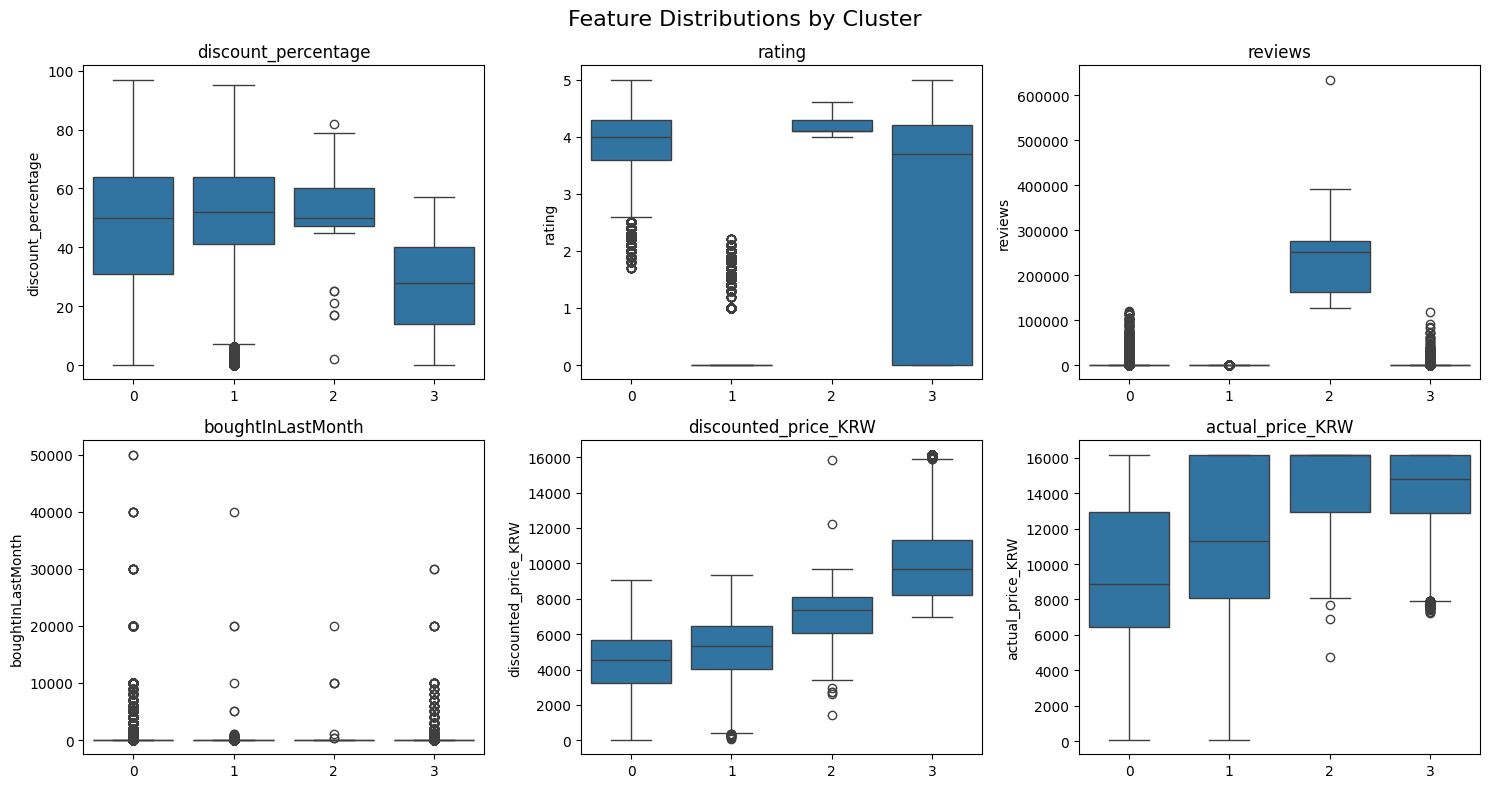

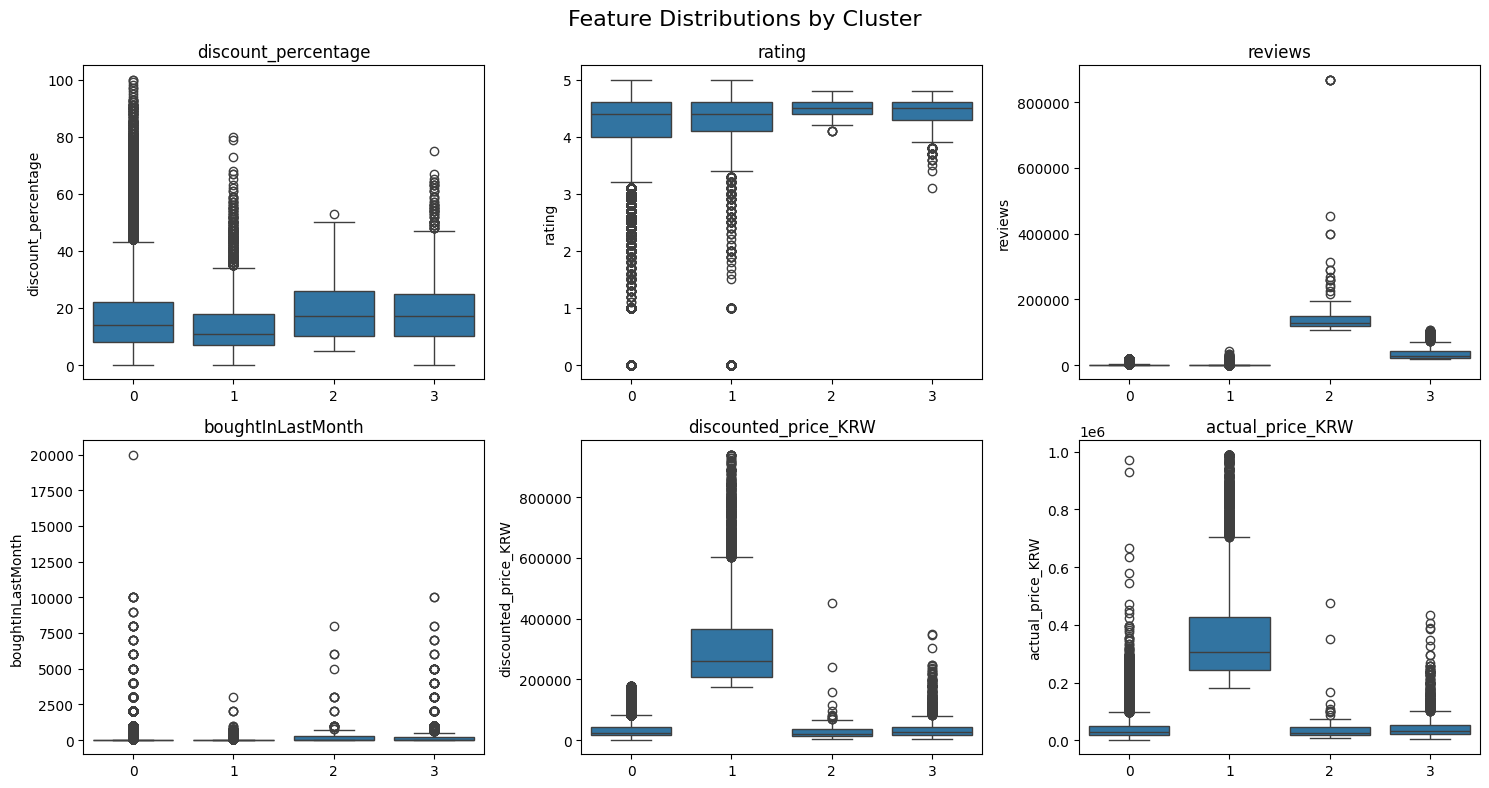

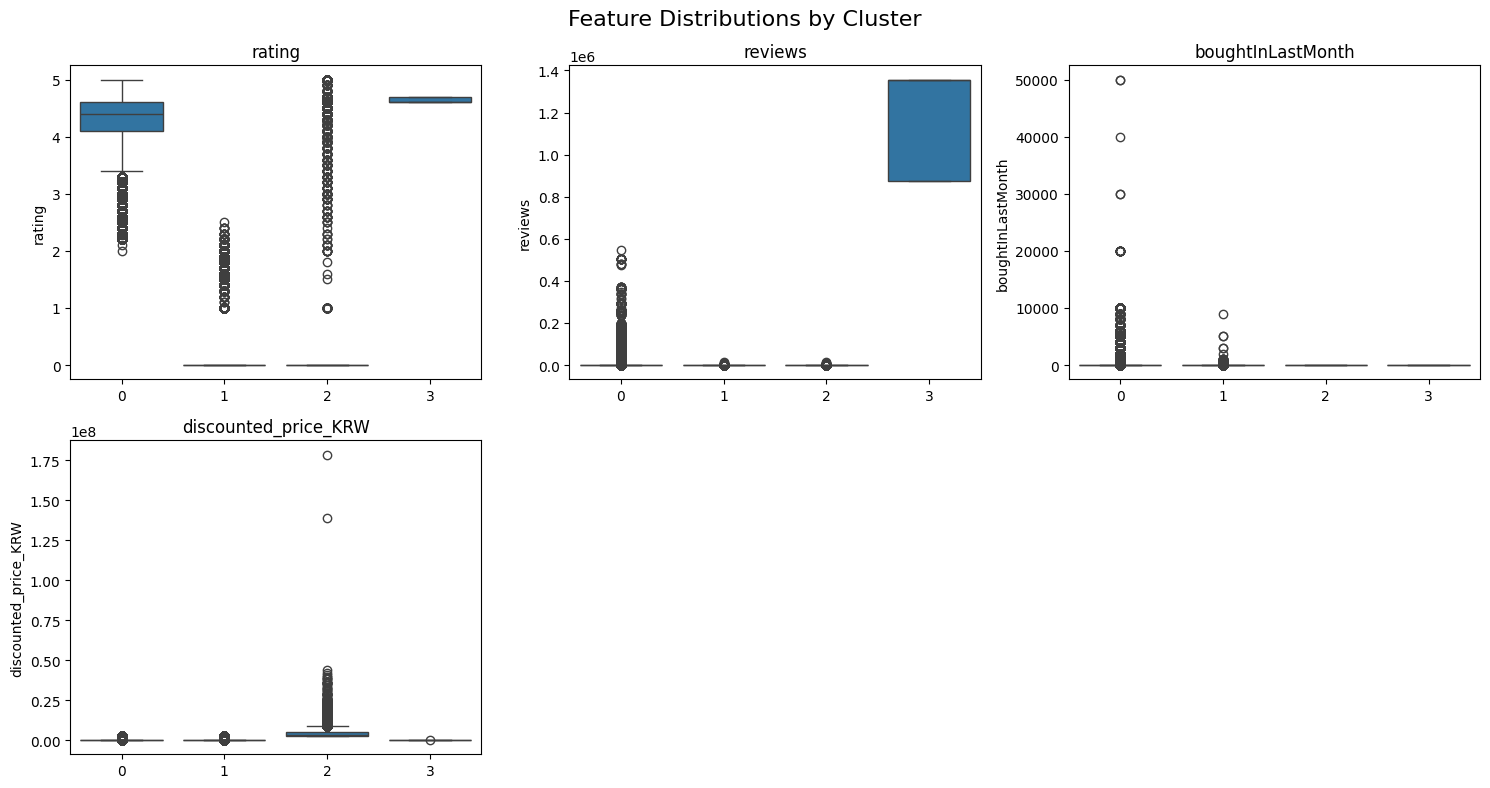

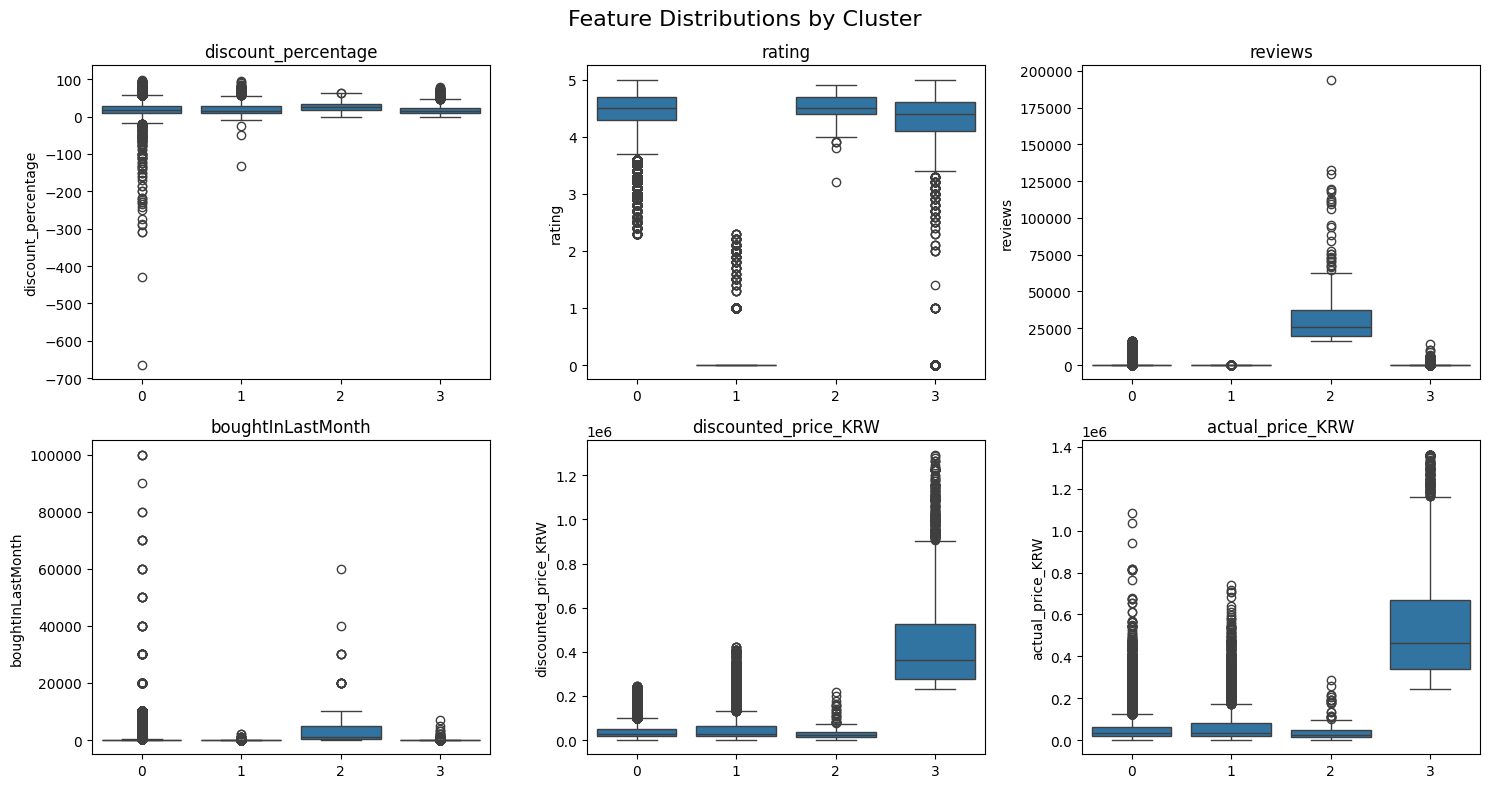

In [105]:
# Usage
plot_feature_distributions(cluster_dfs)